In [1]:
%matplotlib inline

In [2]:
import pickle

In [3]:

import pandas as pd
import torch
from torch import nn


In [4]:
import matplotlib.pyplot as plt

In [5]:
import sys 

In [6]:
sys.path.append('../../')

In [7]:
from omd2l.data.KaggleHouse import KaggleHouse

In [8]:
from omd2l.models.base.Trainer import Trainer

In [9]:
from omd2l.models.linear.LinearRegressionScratch import LinearRegressionScratch
from omd2l.models.linear.LinearRegression import LinearRegression

In [10]:
from omd2l.models.MLP.MLPScratch import MLPScratch
from omd2l.models.MLP.MLP import MLP
 
from omd2l.models.MLP.DropoutMLPScratch import DropoutMLPScratch
from omd2l.models.MLP.DropoutMLPRegressor import DropoutMLPRegressor


In [11]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [12]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [13]:
data.preprocess()
data.train.shape

(1460, 332)

In [14]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(batch_size=data.batch_size, 
                                train=data.train.drop(index=idx),
                                val=data.train.loc[idx]))
    return rets

In [15]:
def k_fold(trainer, data, k, model ):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    avg_val_log_loss = sum(val_loss)/len(val_loss)
    return models, avg_val_log_loss

In [17]:
lr_hparams = {'lr':0.01}
lr_model = LinearRegression(**lr_hparams)

/Users/oualid/opt/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
mlp_hparams = {'num_outputs':1, 'num_hiddens_1':10, 'num_hiddens_2':10,
           'dropout_1':0.1, 'dropout_2':0.1, 'lr':0.1}

In [19]:
mlp_model = DropoutMLPRegressor(**mlp_hparams)

KeyboardInterrupt: 

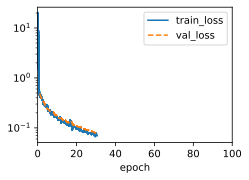

In [20]:
mdls = {'lr': lr_model, 'mlp': mlp_model}
# mdls = {'mlp': mlp_model}

for name, mdl in mdls.items():
    trainer = Trainer(max_epochs=100)
    models, avg_val_log_loss = k_fold(trainer, data, k=5, model=mdl)
    print(f'{name}: average validation log mse = {avg_val_log_loss}')
